# Comparison of ML model and OGGM, PYGEM, GLOGEM on glacier-wide mass balance

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde

import seaborn as sns
import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results

In [2]:
# Read dataframe of measurments
filepath_obs = 'C:/Users/kasj/ML_MB_Norway/Data/NVE_gw_mb/massbalance_gw_Norway.csv'
df_obs = pd.read_csv(filepath_obs, sep=';')
df_obs

,Year,RGIID,BREID,DateMinPrevYear,DateMax,DateMin,Area,Bw,Bs,Ba,Bcalv
0,1978,NaN,26,NaN,01.05.1978,01.10.1978,2.730,2.30,-2.40,-0.10,NaN
1,1979,NaN,26,01.10.1978,01.05.1979,NaN,2.730,2.10,NaN,NaN,NaN
2,1989,RGI60-08.01258,54,NaN,24.05.1989,19.10.1989,3.621,2.38,-2.98,-0.60,NaN
3,1990,RGI60-08.01258,54,19.10.1989,24.05.1990,05.09.1990,3.621,2.60,-2.98,-0.38,NaN
4,1991,RGI60-08.01258,54,05.09.1990,14.05.1991,04.10.1991,3.621,2.25,-2.29,-0.04,NaN
...,...,...,...,...,...,...,...,...,...,...,...
759,2013,RGI60-08.02969,3141,12.10.2012,29.05.2013,24.09.2013,22.541,2.49,-3.29,-0.80,NaN
760,2014,RGI60-08.02969,3141,24.09.2013,24.04.2014,14.10.2014,22.541,2.94,-3.68,-0.74,NaN
761,2015,RGI60-08.02969,3141,14.10.2014,22.04.2015,14.10.2015,22.541,2.90,-1.54,1.36,NaN
762,2016,RGI60-08.02969,3141,14.10.2015,28.04.2016,06.10.2016,22.539,2.92,-2.85,0.07,NaN


In [3]:
# Read dataframes of monthly predictions into test and train dataframes with all data
filepath_pred = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions/all_glaciers_predictions.csv'
df_pred = pd.read_csv(filepath_pred)
df_pred = df_pred.rename(columns={'year':'Year','Ba_pred':'Ba','Bs_pred':'Bs','Bw_pred':'Bw'})
df_pred

,Year,Ba,Bw,Bs,BREID,RGIID
0,1960,-2.242073,1.061117,-3.303190,2320,RGI60-08.00434
1,1961,-0.521958,1.836716,-2.358674,2320,RGI60-08.00434
2,1962,0.315774,2.009975,-1.694202,2320,RGI60-08.00434
3,1963,-1.197595,1.639952,-2.837548,2320,RGI60-08.00434
4,1964,0.258340,1.965160,-1.706820,2320,RGI60-08.00434
...,...,...,...,...,...,...
1979,2017,-0.672011,2.593494,-3.265504,3126,RGI60-08.02966
1980,2018,-0.693289,2.981997,-3.675286,3126,RGI60-08.02966
1981,2019,-1.517612,2.000359,-3.517971,3126,RGI60-08.02966
1982,2020,0.822876,3.814044,-2.991169,3126,RGI60-08.02966


In [4]:
# Read glacier-wide predictiosn per model
filepath_glogem = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/GLOGEM_annual_seasonal_glacier_wide.csv'
df_glogem = pd.read_csv(filepath_glogem)
df_glogem = df_glogem.rename(columns={'ID':'RGIID'})
df_glogem

,RGIID,Year,Ba,Bw,Bs
0,RGI60-08.02650,1980,-1.2965,2.1336,-3.4301
1,RGI60-08.02650,1981,1.0601,3.4973,-2.4372
2,RGI60-08.02650,1982,0.3777,2.7355,-2.3578
3,RGI60-08.02650,1983,1.0841,3.2312,-2.1471
4,RGI60-08.02650,1984,1.1511,3.6574,-2.5063
...,...,...,...,...,...
1275,RGI60-08.01258,2015,-0.8784,1.4670,-2.3454
1276,RGI60-08.01258,2016,-1.7201,1.4397,-3.1598
1277,RGI60-08.01258,2017,-0.1964,1.6806,-1.8770
1278,RGI60-08.01258,2018,-1.8513,1.3354,-3.1867


In [5]:
# Read glacier-wide predictiosn per model
filepath_oggm = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/OGGM_annual_seasonal_glacier_wide.csv'
df_oggm = pd.read_csv(filepath_oggm)
df_oggm = df_oggm.rename(columns={'year':'Year'})
df_oggm

,Year,Ba,Bw,Bs,RGIID
0,1961,-1.180584,2.169184,-3.349768,RGI60-08.00287
1,1962,-0.210309,1.555307,-1.765617,RGI60-08.00287
2,1963,-0.527644,3.222508,-3.750152,RGI60-08.00287
3,1964,2.180276,3.583699,-1.403423,RGI60-08.00287
4,1965,0.424091,2.985545,-2.561454,RGI60-08.00287
...,...,...,...,...,...
1883,2015,1.344163,3.653286,-2.309123,RGI60-08.02969
1884,2016,-0.570878,2.973452,-3.544329,RGI60-08.02969
1885,2017,-0.472488,2.358645,-2.831133,RGI60-08.02969
1886,2018,-0.988100,2.854169,-3.842269,RGI60-08.02969


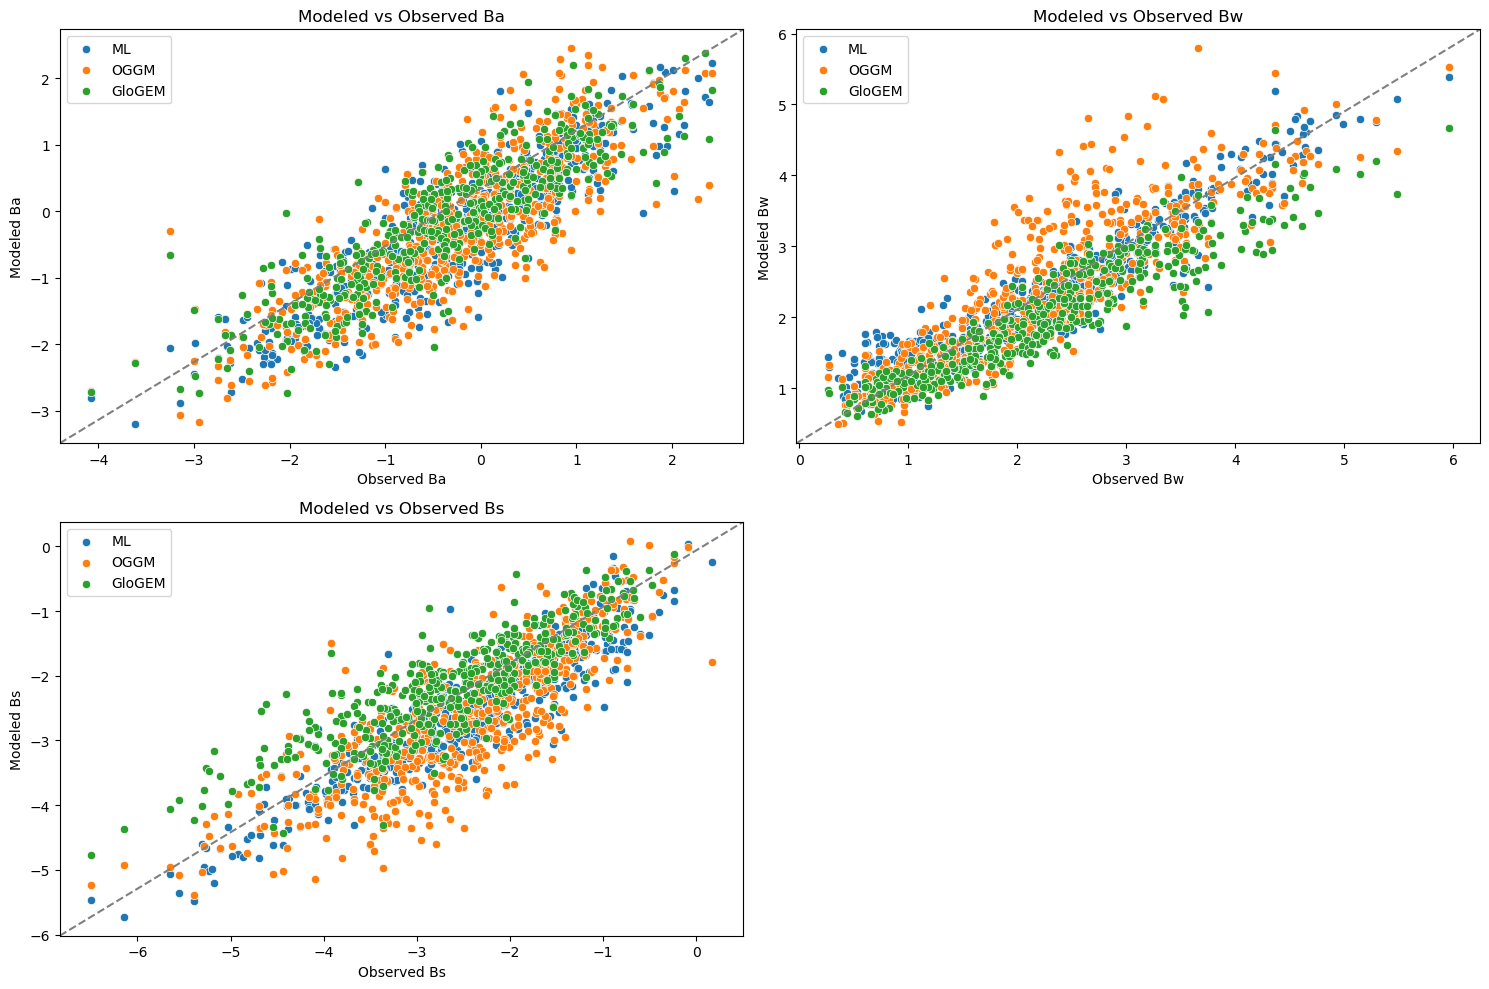

In [6]:
# List of model DataFrames and corresponding labels
models = [(df_pred, 'ML'), (df_oggm, 'OGGM'), (df_glogem, 'GloGEM')]

# Merge observed and model DataFrames on 'RGIID' and 'Year'
merged_dfs = [(df_obs.merge(model, how='inner', on=['RGIID', 'Year']), label) for model, label in models]

# Plotting
metrices = ['Ba', 'Bw', 'Bs']
plt.figure(figsize=(15, 10))
for idx, metric in enumerate(metrices):
    plt.subplot(2, 2, idx+1)
    
    for df, label in merged_dfs:
        sns.scatterplot(x=f'{metric}_x', y=f'{metric}_y', data=df, label=label)
    
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, linestyle='--', color='gray')
    plt.xlabel(f'Observed {metric}')
    plt.ylabel(f'Modeled {metric}')
    plt.title(f'Modeled vs Observed {metric}')
    plt.legend()

plt.tight_layout()
plt.show()

In [7]:
df_obs

,Year,RGIID,BREID,DateMinPrevYear,DateMax,DateMin,Area,Bw,Bs,Ba,Bcalv
0,1978,NaN,26,NaN,01.05.1978,01.10.1978,2.730,2.30,-2.40,-0.10,NaN
1,1979,NaN,26,01.10.1978,01.05.1979,NaN,2.730,2.10,NaN,NaN,NaN
2,1989,RGI60-08.01258,54,NaN,24.05.1989,19.10.1989,3.621,2.38,-2.98,-0.60,NaN
3,1990,RGI60-08.01258,54,19.10.1989,24.05.1990,05.09.1990,3.621,2.60,-2.98,-0.38,NaN
4,1991,RGI60-08.01258,54,05.09.1990,14.05.1991,04.10.1991,3.621,2.25,-2.29,-0.04,NaN
...,...,...,...,...,...,...,...,...,...,...,...
759,2013,RGI60-08.02969,3141,12.10.2012,29.05.2013,24.09.2013,22.541,2.49,-3.29,-0.80,NaN
760,2014,RGI60-08.02969,3141,24.09.2013,24.04.2014,14.10.2014,22.541,2.94,-3.68,-0.74,NaN
761,2015,RGI60-08.02969,3141,14.10.2014,22.04.2015,14.10.2015,22.541,2.90,-1.54,1.36,NaN
762,2016,RGI60-08.02969,3141,14.10.2015,28.04.2016,06.10.2016,22.539,2.92,-2.85,0.07,NaN


In [42]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# Remove rows with NaN values
#df_obs_nonan = df_obs.dropna()

# List of model DataFrames and corresponding labels
models = [(df_pred, 'ML'), (df_oggm, 'OGGM'), (df_glogem, 'GloGEM')]

merged_dfs = [(df_obs.merge(model, how='inner', on=['RGIID', 'Year']), label) for model, label in models]

# Calculate RMSE, MSE, and bias
metrics = {}
valid_dfs = {}

for df, label in merged_dfs:
    metrics[label] = {}
    valid_dfs[label] = {}

    for metric in ['Ba', 'Bw', 'Bs']:
        df_metric = df.dropna(subset=[f'{metric}_x', f'{metric}_y'])
        observed = df_metric[f'{metric}_x']
        modeled = df_metric[f'{metric}_y']
        rmse = root_mean_squared_error(observed, modeled)
        mse = mean_squared_error(observed, modeled)
        bias = np.mean(modeled - observed)
        count = len(df_metric)  # Count valid pairs
        
        metrics[label][metric] = {'rmse': rmse, 'mse': mse, 'bias': bias, 'count': count}
        valid_dfs[label][metric] = df_metric

        print(f'{label} - {metric}: RMSE={rmse:.2f}, MSE={mse:.2f}, Bias={bias:.2f}, Count={count}')




ML - Ba: RMSE=0.50, MSE=0.25, Bias=-0.01, Count=628
ML - Bw: RMSE=0.37, MSE=0.14, Bias=0.07, Count=622
ML - Bs: RMSE=0.43, MSE=0.18, Bias=-0.08, Count=622
OGGM - Ba: RMSE=0.61, MSE=0.37, Bias=0.03, Count=610
OGGM - Bw: RMSE=0.55, MSE=0.31, Bias=0.17, Count=604
OGGM - Bs: RMSE=0.64, MSE=0.41, Bias=-0.14, Count=604
GloGEM - Ba: RMSE=0.57, MSE=0.32, Bias=0.20, Count=430
GloGEM - Bw: RMSE=0.49, MSE=0.24, Bias=-0.24, Count=428
GloGEM - Bs: RMSE=0.70, MSE=0.50, Bias=0.44, Count=428


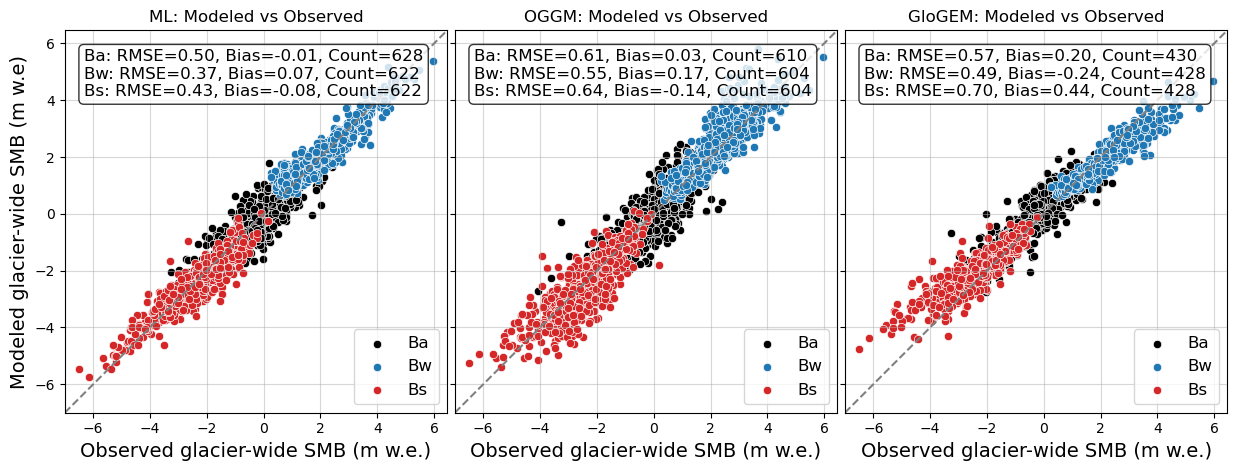

In [31]:
# Create a 2x2 plot grid (adjust this as needed for the number of models)
colors = {
    'Bs': 'C3',
    'Bw': 'C0',
    'Ba': 'black'
}

fig, axs = plt.subplots(1,3, figsize=(15, 5), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

# Define the limit for equal scaling based on the combined data range
combined_min = min(df_obs[['Ba', 'Bw', 'Bs']].min().min(), df_pred[['Ba', 'Bw', 'Bs']].min().min(), 
                   df_oggm[['Ba', 'Bw', 'Bs']].min().min(), df_glogem[['Ba', 'Bw', 'Bs']].min().min())

combined_max = max(df_obs[['Ba', 'Bw', 'Bs']].max().max(), df_pred[['Ba', 'Bw', 'Bs']].max().max(), 
                   df_oggm[['Ba', 'Bw', 'Bs']].max().max(), df_glogem[['Ba', 'Bw', 'Bs']].max().max())


for idx, (df, label) in enumerate(merged_dfs):
    ax = axs[idx]
    
    for metric in ['Ba', 'Bw', 'Bs']:
        sns.scatterplot(x=f'{metric}_x', y=f'{metric}_y', data=valid_dfs[label][metric], color=colors[metric], ax=ax, label=metric)
    
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color='gray')
    ax.set_xlabel('Observed glacier-wide SMB (m w.e.)', fontsize=14)
    ax.set_ylabel('Modeled glacier-wide SMB (m w.e)', fontsize=14)
    ax.set_aspect('equal', 'box')
    ax.set_xlim(combined_min-0.5, combined_max+0.5)
    ax.set_ylim(combined_min-0.5, combined_max+0.5)
    ax.set_title(f'{label}: Modeled vs Observed')
    ax.legend(loc='lower right', fontsize=12)
    
    # Annotate with RMSE, MSE, Bias, and Count
    textstr = '\n'.join([
        f"{metric}: RMSE={metrics[label][metric]['rmse']:.2f}, Bias={metrics[label][metric]['bias']:.2f}, Count={metrics[label][metric]['count']}"
        for metric in ['Ba', 'Bw', 'Bs']
        #f"{metric}: RMSE={metrics[label][metric]['rmse']:.2f}, MSE={metrics[label][metric]['mse']:.2f}, Bias={metrics[label][metric]['bias']:.2f}, Count={metrics[label][metric]['count']}"
        #for metric in ['Ba', 'Bw', 'Bs']
    ])
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes,
            verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax.grid(alpha=0.5)
# Turn off any unused subplots (if any)
for idx in range(len(merged_dfs), len(axs)):
    fig.delaxes(axs[idx])

plt.subplots_adjust(wspace=0.02)
#plt.tight_layout()
plt.show()

ML - Ba: RMSE=0.57, MSE=0.33, Bias=-0.10, Count=229
ML - Bw: RMSE=0.35, MSE=0.13, Bias=0.05, Count=225
ML - Bs: RMSE=0.56, MSE=0.31, Bias=-0.16, Count=225
OGGM - Ba: RMSE=0.59, MSE=0.34, Bias=0.01, Count=229
OGGM - Bw: RMSE=0.66, MSE=0.43, Bias=0.24, Count=225
OGGM - Bs: RMSE=0.67, MSE=0.45, Bias=-0.23, Count=225
GloGEM - Ba: RMSE=0.56, MSE=0.31, Bias=0.20, Count=182
GloGEM - Bw: RMSE=0.42, MSE=0.18, Bias=-0.23, Count=182
GloGEM - Bs: RMSE=0.71, MSE=0.50, Bias=0.43, Count=182


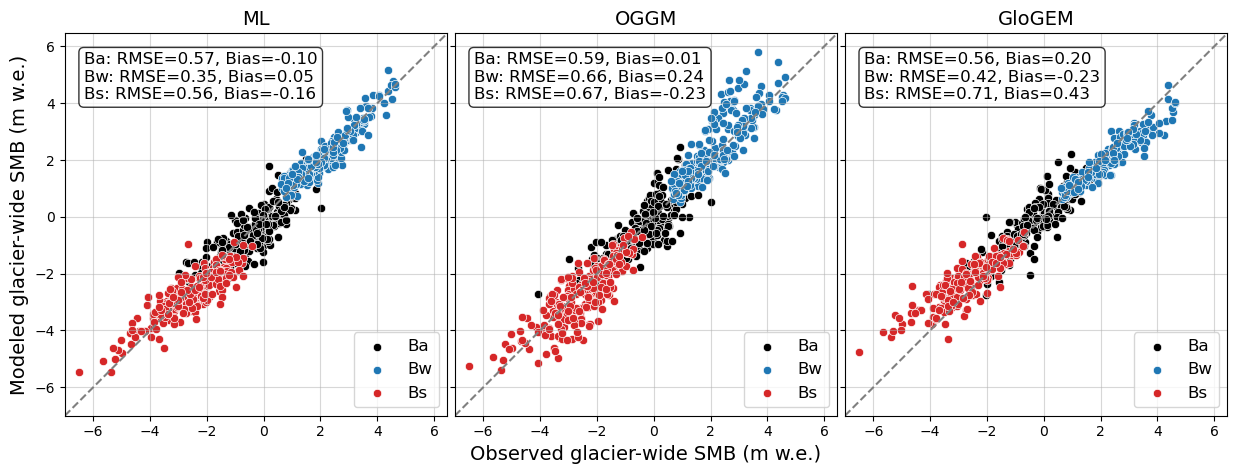

In [43]:
test_glaciers = ['00434', '00449', '01013', '01026', '01258', '01286', '01484', '01598', '02384', '02650', '02916', '02918', '02920', '02969']

# Set the start and end years for the filter
start_year = 1961
end_year = 2019

# Function to filter DataFrame based on RGIID ending and year range
def filter_df_by_rgiid_and_year(df, test_glaciers, start_year, end_year):
    return df[df['RGIID'].str.endswith(tuple(test_glaciers)) & (df['Year'] >= start_year) & (df['Year'] <= end_year)]

# Filter the DataFrames
df_obs_nonan = df_obs.dropna(subset=['RGIID'])
df_obs_nonan = filter_df_by_rgiid_and_year(df_obs_nonan, test_glaciers, start_year, end_year)
df_pred_filtered = filter_df_by_rgiid_and_year(df_pred, test_glaciers, start_year, end_year)
df_oggm_filtered = filter_df_by_rgiid_and_year(df_oggm, test_glaciers, start_year, end_year)
df_glogem_filtered = filter_df_by_rgiid_and_year(df_glogem, test_glaciers, start_year, end_year)


# List of model DataFrames and corresponding labels
models = [(df_pred_filtered, 'ML'), (df_oggm_filtered, 'OGGM'), (df_glogem_filtered, 'GloGEM')]

# Merge observed and model DataFrames on 'RGIID' and 'Year'
merged_dfs = [(df_obs_nonan.merge(model, how='inner', on=['RGIID', 'Year']), label) for model, label in models]

# Calculate RMSE, MSE, and bias
metrics = {}
valid_dfs = {}

for df, label in merged_dfs:
    metrics[label] = {}
    valid_dfs[label] = {}

    for metric in ['Ba', 'Bw', 'Bs']:
        df_metric = df.dropna(subset=[f'{metric}_x', f'{metric}_y'])
        observed = df_metric[f'{metric}_x']
        modeled = df_metric[f'{metric}_y']
        rmse = root_mean_squared_error(observed, modeled)
        mse = mean_squared_error(observed, modeled)
        bias = np.mean(modeled - observed)
        count = len(df_metric)  # Count valid pairs
        
        metrics[label][metric] = {'rmse': rmse, 'mse': mse, 'bias': bias, 'count': count}
        valid_dfs[label][metric] = df_metric

        print(f'{label} - {metric}: RMSE={rmse:.2f}, MSE={mse:.2f}, Bias={bias:.2f}, Count={count}')

colors = {
    'Bs': 'C3',
    'Bw': 'C0',
    'Ba': 'black'
}
        
# Create a 2x2 plot grid (adjust this as needed for the number of models)
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

# Define the limit for equal scaling based on the combined data range
combined_min = min(df_obs[['Ba', 'Bw', 'Bs']].min().min(), df_pred[['Ba', 'Bw', 'Bs']].min().min(), 
                   df_oggm[['Ba', 'Bw', 'Bs']].min().min(), df_glogem[['Ba', 'Bw', 'Bs']].min().min())

combined_max = max(df_obs[['Ba', 'Bw', 'Bs']].max().max(), df_pred[['Ba', 'Bw', 'Bs']].max().max(), 
                   df_oggm[['Ba', 'Bw', 'Bs']].max().max(), df_glogem[['Ba', 'Bw', 'Bs']].max().max())

for idx, (df, label) in enumerate(merged_dfs):
    ax = axs[idx]
    
    for metric in ['Ba', 'Bw', 'Bs']:
        sns.scatterplot(x=f'{metric}_x', y=f'{metric}_y', data=valid_dfs[label][metric], ax=ax,color=colors[metric], label=metric)
    
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color='gray')
    ax.set_xlabel('Observed glacier-wide SMB (m w.e.)', fontsize=14)
    ax.set_ylabel('Modeled glacier-wide SMB (m w.e.)', fontsize=14)
    ax.set_title(f'{label}', fontsize=14)
    ax.set_aspect('equal', 'box')
    ax.set_xlim(combined_min-0.5, combined_max+0.5)
    ax.set_ylim(combined_min-0.5, combined_max+0.5)
    ax.grid(alpha=0.5)
    ax.legend(loc = 'lower right', fontsize=12)
    
    # Annotate with RMSE, MSE, Bias, and Count
    textstr = '\n'.join([
        #f"{metric}: RMSE={metrics[label][metric]['rmse']:.2f}, MSE={metrics[label][metric]['mse']:.2f}, Bias={metrics[label][metric]['bias']:.2f}, Count={metrics[label][metric]['count']}"
        f"{metric}: RMSE={metrics[label][metric]['rmse']:.2f}, Bias={metrics[label][metric]['bias']:.2f}"

        for metric in ['Ba', 'Bw', 'Bs']
    ])

    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axs[0].set_xlabel('')
axs[2].set_xlabel('')
    
# Turn off any unused subplots (if any)
for idx in range(len(merged_dfs), len(axs)):
    fig.delaxes(axs[idx])

plt.subplots_adjust(wspace=0.02)
#plt.tight_layout()
plt.show()


In [50]:
test_glaciers = ['00434', '00449', '01013', '01026', '01258', '01286', '01484', '01598', '02384', '02650', '02916', '02918', '02920', '02969']
train_glaciers = ['00287','00295','00868','00966','00987','01126','01186','01217','01657','01779','02017','02436','02458','02643','02666','02962','02963','02966']
all_glaciers = test_glaciers + train_glaciers

# Set the start and end years for the filter
start_year = 1962
end_year = 2021

# Function to filter DataFrame based on RGIID ending and year range
def filter_df_by_rgiid_and_year(df, test_glaciers, start_year, end_year):
    return df[df['RGIID'].str.endswith(tuple(test_glaciers)) & (df['Year'] >= start_year) & (df['Year'] <= end_year)]

# Filter the DataFrames
#df_obs_nonan = df_obs.dropna(subset=['RGIID'])
df_obs_filtered = filter_df_by_rgiid_and_year(df_obs, all_glaciers, start_year, end_year)
df_pred_filtered = filter_df_by_rgiid_and_year(df_pred, all_glaciers, start_year, end_year)
df_oggm_filtered = filter_df_by_rgiid_and_year(df_oggm, all_glaciers, start_year, end_year)
df_glogem_filtered = filter_df_by_rgiid_and_year(df_glogem, all_glaciers, start_year, end_year)


# List of model DataFrames and corresponding labels
models = [(df_pred_filtered, 'ML'), (df_oggm_filtered, 'OGGM'), (df_glogem_filtered, 'GloGEM')]

# Merge observed and model DataFrames on 'RGIID' and 'Year'
merged_dfs = [(df_obs_filtered.merge(model, how='inner', on=['RGIID', 'Year']), label) for model, label in models]


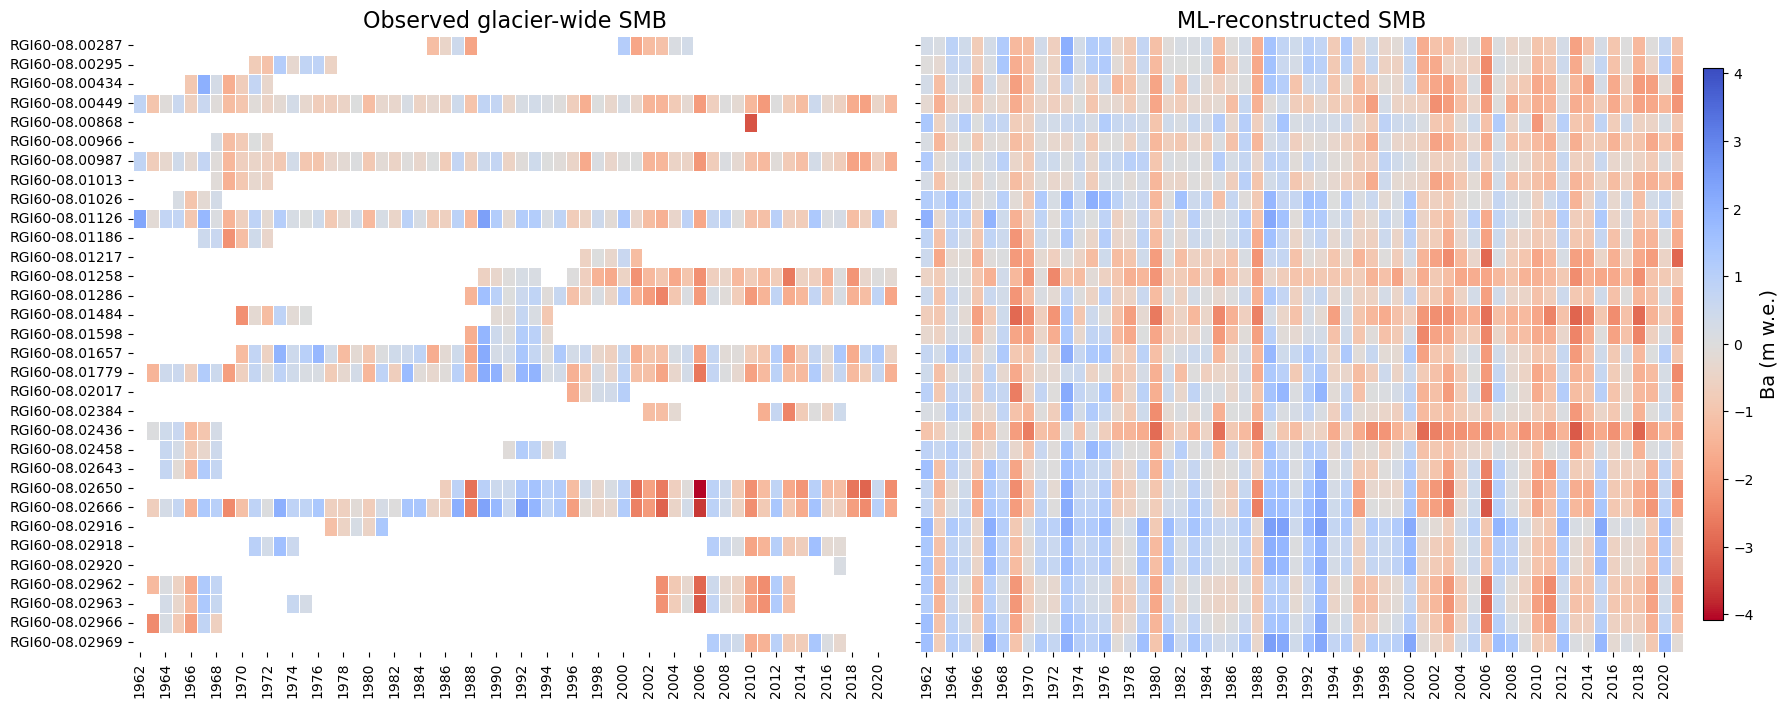

In [80]:
# Function to create a pivot table for heatmap
def create_pivot_table(df, value, index, columns):
    pivot_df = df.pivot_table(index=index, columns=columns, values=value, aggfunc='mean')
    return pivot_df

# Create pivot tables
obs_pivot = create_pivot_table(df_obs_nonan, 'Ba', 'RGIID', 'Year')
pred_pivot = create_pivot_table(df_pred_filtered, 'Ba', 'RGIID', 'Year')


# Determine the combined min and max for colorscale
combined_min = min(obs_pivot.min().min(), pred_pivot.min().min())
#combined_max = max(obs_pivot.max().max(), pred_pivot.max().max())
combined_max = -combined_min

# Create heatmaps
fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

sns.heatmap(obs_pivot, cmap='coolwarm_r', ax=axs[0], cbar=False, linewidths=.5, linecolor='white', mask=obs_pivot.isnull(), vmin=combined_min, vmax=combined_max)
axs[0].set_title('Observed glacier-wide SMB', fontsize=16)
axs[0].set_xlabel('')
axs[0].set_ylabel('')
sns.heatmap(pred_pivot, cmap='coolwarm_r', ax=axs[1], cbar=False, linewidths=.5, linecolor='white', mask=pred_pivot.isnull(), vmin=combined_min, vmax=combined_max)
axs[1].set_title('ML-reconstructed SMB', fontsize=16)
axs[1].set_xlabel('')
axs[1].set_ylabel('')

# Create a single colorbar
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.69])  # Coordinates: [left, bottom, width, height]
cbar = fig.colorbar(axs[1].collections[0], cax=cbar_ax, label='Ba (m w.e.)')
cbar.set_label('Ba (m w.e.)', fontsize=14)

plt.subplots_adjust(wspace=0.03)
#plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate the colorbar
plt.show()

C:\Users\kasj\AppData\Local\Temp\ipykernel_26060\3508467523.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate the colorbar


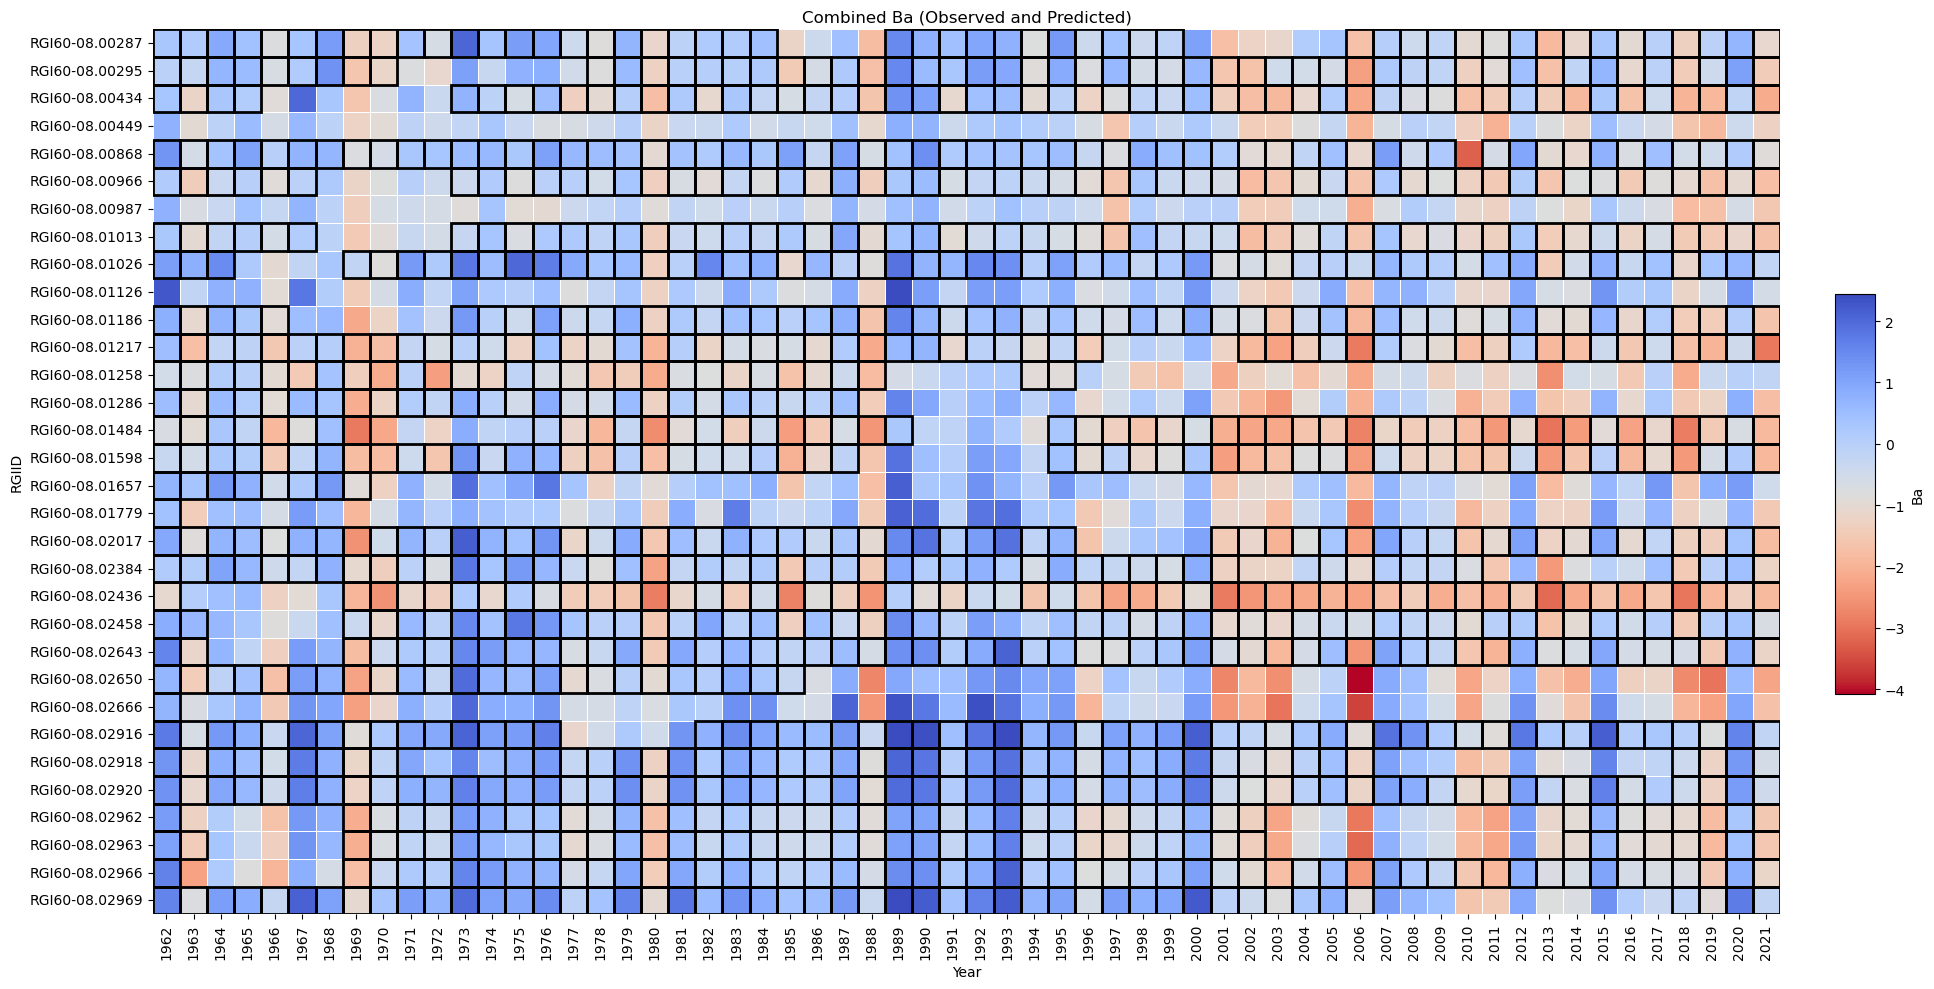

In [72]:
# Function to create a pivot table for heatmap
def create_pivot_table(df, value, index, columns):
    pivot_df = df.pivot_table(index=index, columns=columns, values=value, aggfunc='mean')
    return pivot_df

# Create pivot tables
obs_pivot = create_pivot_table(df_obs_nonan, 'Ba', 'RGIID', 'Year')
pred_pivot = create_pivot_table(df_pred_filtered, 'Ba', 'RGIID', 'Year')

# Merge the pivot tables by filling NaN values in obs_pivot with pred_pivot
combined_pivot = obs_pivot.combine_first(pred_pivot)
# Determine which cells are filled from pred_pivot
pred_filled_mask = obs_pivot.isnull() & ~pred_pivot.isnull()

# Determine the combined min and max for the colorscale
combined_min = min(obs_pivot.min().min(), pred_pivot.min().min())
combined_max = max(obs_pivot.max().max(), pred_pivot.max().max())

# Plot the heatmap
fig, ax = plt.subplots(figsize=(20, 10))

sns.heatmap(combined_pivot, cmap='coolwarm_r', ax=ax, cbar=False, linewidths=.5, linecolor='white', vmin=combined_min, vmax=combined_max)

# Bold outline around cells filled from pred_pivot
for i in range(combined_pivot.shape[0]):
    for j in range(combined_pivot.shape[1]):
        if pred_filled_mask.iloc[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2))

ax.set_title('Combined Ba (Observed and Predicted)')
ax.set_xlabel('Year')
ax.set_ylabel('RGIID')

# Create a single colorbar
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Coordinates: [left, bottom, width, height]
cbar = fig.colorbar(ax.collections[0], cax=cbar_ax, label='Ba')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate the colorbar
plt.show()


C:\Users\kasj\AppData\Local\Temp\ipykernel_26060\3311312891.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate the colorbar


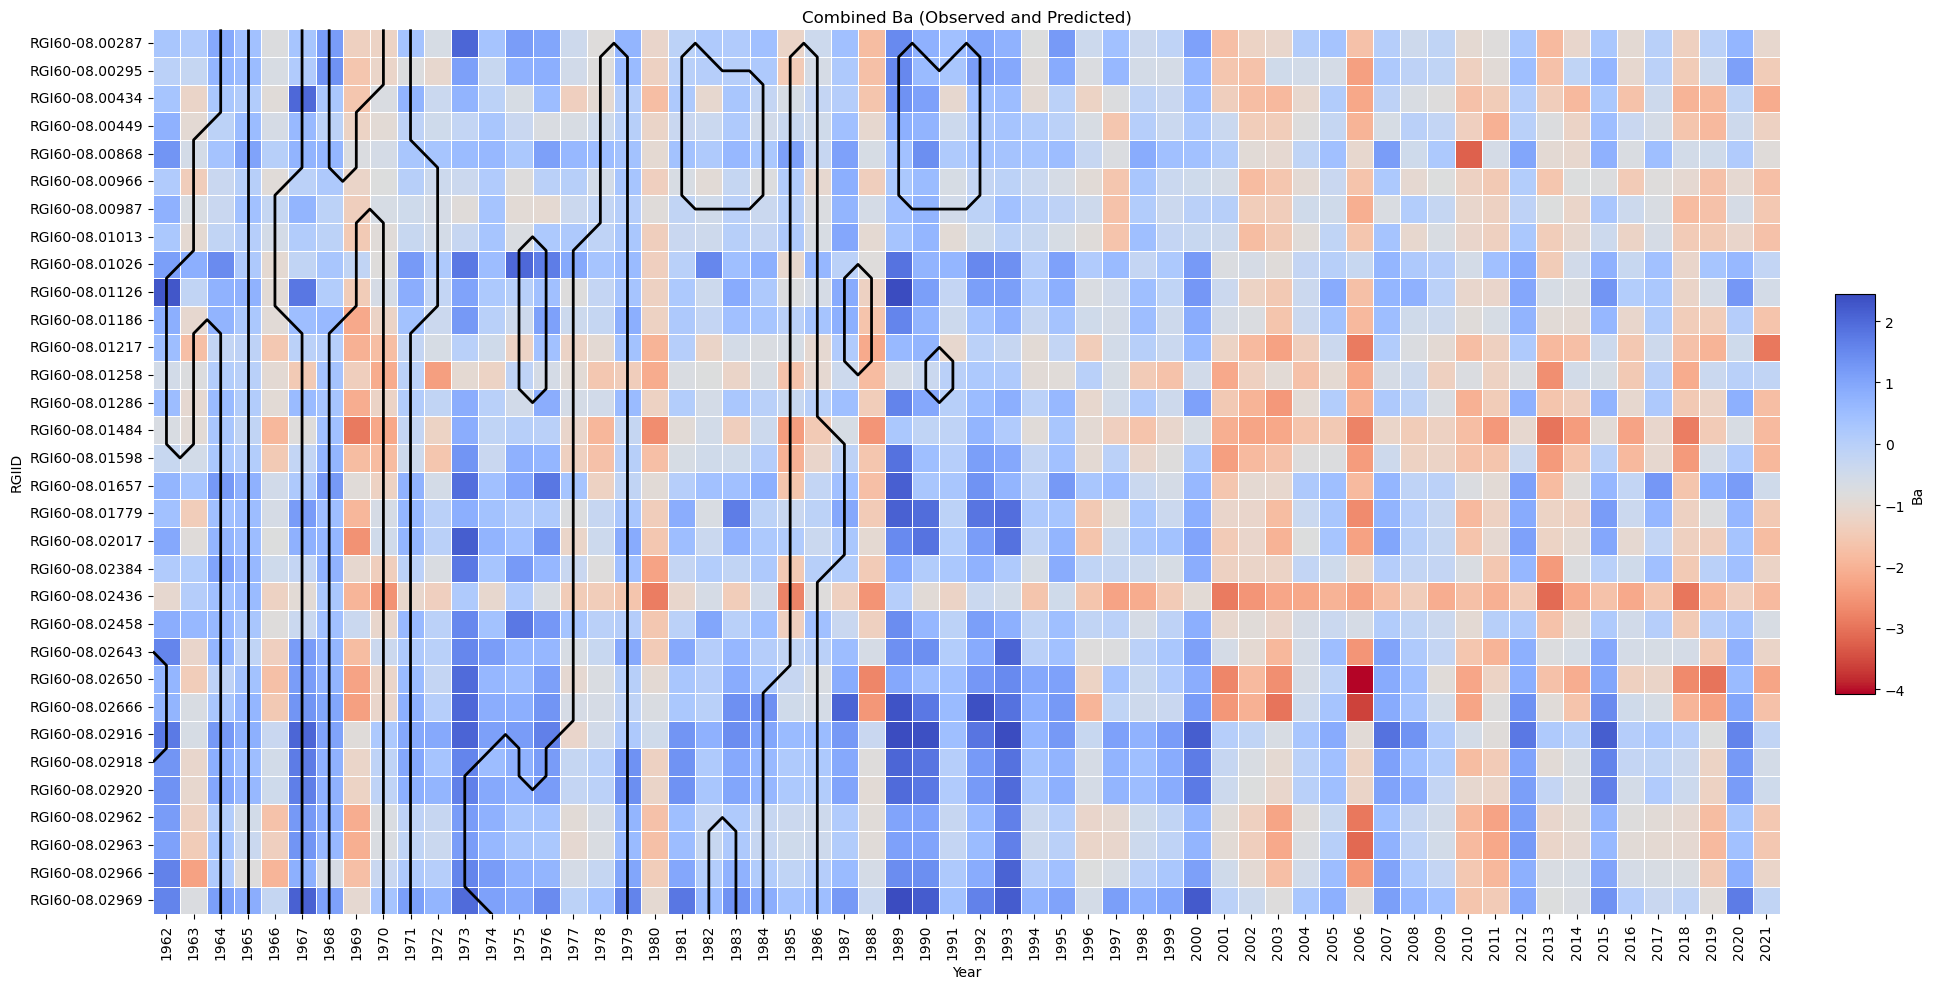

In [73]:
# Function to create a pivot table for heatmap
def create_pivot_table(df, value, index, columns):
    pivot_df = df.pivot_table(index=index, columns=columns, values=value, aggfunc='mean')
    return pivot_df

# Create pivot tables
obs_pivot = create_pivot_table(df_obs_nonan, 'Ba', 'RGIID', 'Year')
pred_pivot = create_pivot_table(df_pred_filtered, 'Ba', 'RGIID', 'Year')

# Merge the pivot tables by filling NaN values in obs_pivot with pred_pivot
combined_pivot = obs_pivot.combine_first(pred_pivot)
# Determine which cells are filled from pred_pivot
pred_filled_mask = obs_pivot.isnull() & ~pred_pivot.isnull()

# Determine the combined min and max for the colorscale
combined_min = min(obs_pivot.min().min(), pred_pivot.min().min())
combined_max = max(obs_pivot.max().max(), pred_pivot.max().max())

# Plot the heatmap
fig, ax = plt.subplots(figsize=(20, 10))

sns.heatmap(combined_pivot, cmap='coolwarm_r', ax=ax, cbar=False, linewidths=.5, linecolor='white', vmin=combined_min, vmax=combined_max)

# Creating a contour plot to highlight contiguous regions filled with predicted values
# Contour needs an array, so we convert the mask into an integer array
mask_array = pred_filled_mask.astype(int).to_numpy()
Y, X = np.meshgrid(range(mask_array.shape[1]), range(mask_array.shape[0]))

# Draw contours using plotly's contour function
cont = plt.contour(X, Y, mask_array, levels=[0.5], colors='black', linewidths=2)

ax.set_title('Combined Ba (Observed and Predicted)')
ax.set_xlabel('Year')
ax.set_ylabel('RGIID')

# Create a single colorbar
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Coordinates: [left, bottom, width, height]
cbar = fig.colorbar(ax.collections[0], cax=cbar_ax, label='Ba')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate the colorbar
plt.show()
